# Alliance log parsing

Import some basic packages

In [2]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
date = datetime(2018, 3, 1)

In [4]:
fname = Path('/media/fwv14jru/Elements/IGP/data') / 'nmea_logs' / f'{date:%Y%m%d}.log'

In [13]:
# ggas = {'datetime': [], 'timestamp': [], 'longitude': [], 'latitude': []}
# hdts = {'datetime': [], 'heading': []}
# inmwv = {'datetime': [], 'wind_speed': [], 'wind_angle': [], 'wind_status': [], 'wind_angle_reference': []}
# vhws = {'datetime': [], }

# with fname.open('r') as f:
#     for line in tqdm(f.readlines()):
#         try:
#             msg = pynmea2.NMEASentence.parse(line)
# #             if isinstance(msg, pynmea2.talker.GGA):                
# #                 ggas['datetime'].append(msg.datetime_str)
# #                 ggas['timestamp'].append(datetime.combine(date, msg.timestamp))
# #                 ggas['longitude'].append(msg.longitude)
# #                 ggas['latitude'].append(msg.latitude)
# #             elif isinstance(msg, pynmea2.talker.HDT):
# #                 hdts['datetime'].append(msg.datetime_str)
# #                 hdts['heading'].append(float(msg.heading))
# #             elif isinstance(msg, pynmea2.talker.MWV):
# #                 inmwv['datetime'].append(msg.datetime_str)
# #                 inmwv['wind_speed'].append(float(msg.wind_speed))
# #                 inmwv['wind_angle'].append(float(msg.wind_angle))
# #                 inmwv['wind_status'].append(str(msg.status))
# #                 inmwv['wind_angle_reference'].append(str(msg.reference))
#             if isinstance(msg, pynmea2.talker.VHW):
#                 vhws['datetime'].append(msg.datetime_str)
#                 break
#         except pynmea2.ParseError:
#             pass

In [5]:
from parse_logs import AllianceComposite

In [6]:
msg_list = [
    dict(talker='GGA', fields=(('datetime_str',), ('longitude',), ('latitude',))),
    dict(talker='HDT', fields=(('datetime_str',), ('heading', float))),
    dict(talker='MWV', fields=(('datetime_str',), ('status', str), ('reference', str),
                               ('wind_speed', float), ('wind_angle', float))),
    dict(talker='VHW', fields=(('datetime_str',), ('water_speed_knots', float), )),
]

In [7]:
c = AllianceComposite(fname, date)
c.process(msg_list)
sub_df = c.average_over_time(freq='10T')

100%|██████████| 805127/805127 [00:17<00:00, 45626.17it/s]


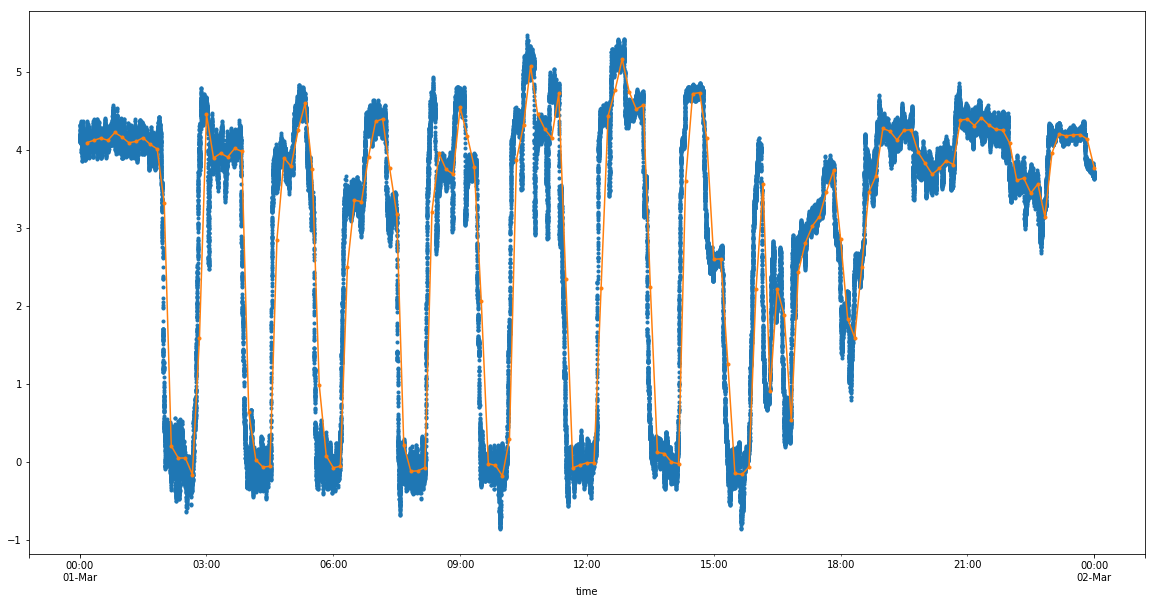

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))
c.df.water_speed.plot(ax=ax, marker='.', linestyle='')
sub_df.water_speed.plot(ax=ax, marker='.', linestyle='-')

## Convert to xarray dataset and save to netCDF file

In [16]:
import pint

In [17]:
ureg = pint.UnitRegistry()

In [18]:
ds = df0.to_xarray()
ds.longitude.attrs['units'] = 'degrees_east'
ds.latitude.attrs['units'] = 'degrees_north'

In [19]:
ds.wind_speed.values = ds.wind_speed.values * (1 * ureg.nautical_miles_per_hour).to(ureg.meter / ureg.second).m
ds.wind_speed.attrs['units'] = 'm s**-1'
ds.wind_speed.attrs['long_name'] = 'wind speed'

In [21]:
outdir = mypaths.igp_data_dir / 'nmea_processed'
outdir.mkdir(exist_ok=True)

In [25]:
ds

<xarray.Dataset>
Dimensions:               (time: 86400)
Coordinates:
  * time                  (time) datetime64[ns] 2018-02-23 ...
Data variables:
    latitude              (time) float64 66.58 66.58 66.58 66.58 66.58 66.58 ...
    longitude             (time) float64 -22.63 -22.63 -22.63 -22.63 -22.63 ...
    wind_angle            (time) float64 259.0 169.2 260.0 169.6 258.0 168.1 ...
    wind_angle_reference  (time) object 'R' 'T' 'R' 'T' 'R' 'T' 'R' 'T' 'R' ...
    wind_speed            (time) float64 18.88 19.55 18.78 20.42 19.39 19.96 ...
    wind_status           (time) object 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' 'A' ...
    heading               (time) float64 275.8 275.9 275.9 276.1 275.8 275.7 ...

In [22]:
ds.to_netcdf(path=outdir / f'alliance_nmea_gga_hdt_mwv_vhw_{date:%Y%m%d}.nc',
             encoding=dict(time=dict(units='seconds since 1900-01-01 00:00:0.0',
                                     calendar='gregorian')))